# Predictive Risk Classification of Financial Distress Using ESG Indicators

### Table Of Contents

1. [Defining Target Variable](#Defining-Target-Variable)
2. [Model Construction](#Model-Construction)
   - 2.1 [Logistic Regression](#Logistic-Regression)
   - 2.2 [XGBoost](#XGBoost)
3. [Model Interpretation](#Model-Interpretation)
4. [Model Limitations and Own Conclusions](#Model-Limitations-and-Own-Conclusions)

# Project Overview

**Goal** - Develop a binary risk classification model using ESG (Environmental, Social, Governance) indicators to predict financial distress as defined by the Altman Z-Score.
purpose of this model is to identify whether a ESG data can act as a warining risk signal indicator

 - **1**. We will Define the Target Variable (Altman Z-Score) and classify companies into two categories based on their scores. For the Model i choose thershold of**1.8** as the cutoff for Distress and above are Safe Zone. [Disclaimer - Reason for binary classificaton is to simplify the model and focus on identifying companies at risk and since we don't have a more data to define more multi class model, i will be using binary classification for this project to avoid bias between class]

 - **2** We will use two models - Logistic Regression as base model and XGBoost as  to predict the risk of financial distress based on ESG data.

 - **3**. We will interpret the results of the models to understand which ESG factors are most influential in predicting financial distress. 

In [57]:
# Operational Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from xgboost import XGBClassifier


In [58]:
#  Load the dataset
al_model = pd.read_csv('FE_Comapnies.csv')

In [59]:
al_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   altman_score                            1285 non-null   float64
 1   piotroski_score                         1285 non-null   float64
 2   involvement_msci.Controversial Weapons  1285 non-null   float64
 3   involvement_msci.Gambling               1285 non-null   float64
 4   involvement_msci.Tobacco Products       1285 non-null   float64
 5   involvement_msci.Alcoholic Beverages    1285 non-null   float64
 6   Controversies_score_ESG                 1285 non-null   float64
 7   global_target_aligned                   1285 non-null   int64  
 8   SBTI_reduction_aligned                  1285 non-null   int64  
 9   Tempurature_aligned                     1285 non-null   int64  
dtypes: float64(7), int64(3)
memory usage: 100.5 KB


# Defining Target Variable

In [60]:
# Creating Target Variable
# Since Dataset is small and limited proxy varibale directly linked to target variable, I will be using binary classification for this project. I will be using 1.8 as the cutoff for Distress and above are Safe Zone. 

def risk_class(altman_score):
    if altman_score < 1.81:
        return 'Distress Zone'
    else:
        return 'Safe Zone'
    
al_model['Risk_class'] = al_model['altman_score'].apply(risk_class)


In [61]:
# Target variable encoding

target = {
    'Safe Zone': 0,
    'Distress Zone': 1,
}

al_model['Risk_class'] = al_model['Risk_class'].map(target)


In [62]:
al_model

,altman_score,piotroski_score,involvement_msci.Controversial Weapons,involvement_msci.Gambling,involvement_msci.Tobacco Products,involvement_msci.Alcoholic Beverages,Controversies_score_ESG,global_target_aligned,SBTI_reduction_aligned,Tempurature_aligned,Risk_class
0,4.08,9.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0
1,1.63,7.0,0.0,0.0,0.0,0.0,2.0,1,1,0,1
2,0.70,8.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
3,1.15,6.0,0.0,0.0,0.0,0.0,2.0,1,0,1,1
4,1.91,7.0,0.0,0.0,0.0,0.0,2.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1280,4.57,7.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1281,-3.89,3.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
1282,-7.52,5.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
1283,46.23,7.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


In [63]:
al_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   altman_score                            1285 non-null   float64
 1   piotroski_score                         1285 non-null   float64
 2   involvement_msci.Controversial Weapons  1285 non-null   float64
 3   involvement_msci.Gambling               1285 non-null   float64
 4   involvement_msci.Tobacco Products       1285 non-null   float64
 5   involvement_msci.Alcoholic Beverages    1285 non-null   float64
 6   Controversies_score_ESG                 1285 non-null   float64
 7   global_target_aligned                   1285 non-null   int64  
 8   SBTI_reduction_aligned                  1285 non-null   int64  
 9   Tempurature_aligned                     1285 non-null   int64  
 10  Risk_class                              1285 non-null   int6

In [64]:
# Target Variable is quite balanced

al_model['Risk_class'].value_counts()

Risk_class
0    766
1    519
Name: count, dtype: int64

<Axes: >

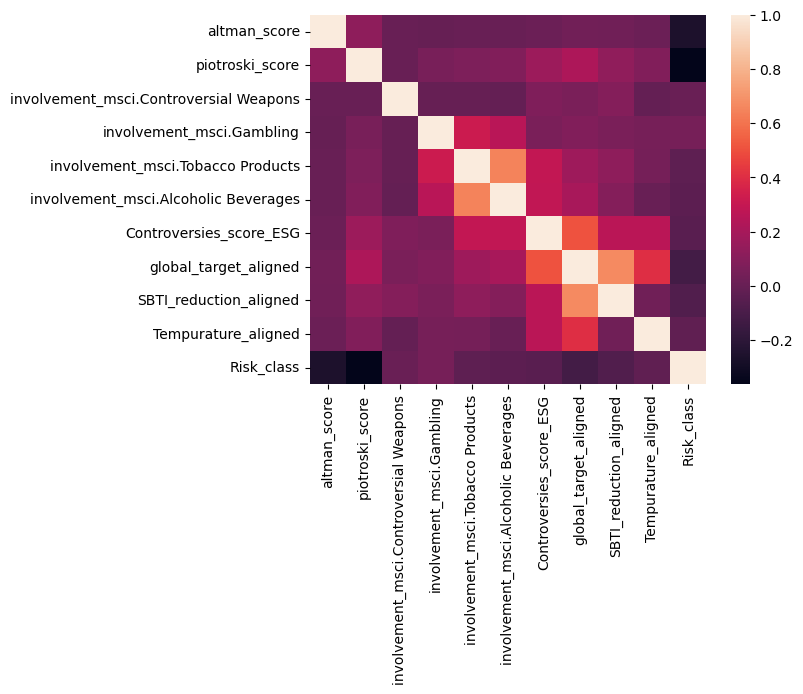

In [65]:
# Correlation between risk class and piotroski score is less correlated and relationship is weak

sns.heatmap(al_model.corr(numeric_only=True))

In [66]:
print(al_model.isna().sum())

altman_score                              0
piotroski_score                           0
involvement_msci.Controversial Weapons    0
involvement_msci.Gambling                 0
involvement_msci.Tobacco Products         0
involvement_msci.Alcoholic Beverages      0
Controversies_score_ESG                   0
global_target_aligned                     0
SBTI_reduction_aligned                    0
Tempurature_aligned                       0
Risk_class                                0
dtype: int64


# Model Construction

In [67]:
# Preprocessing x and y
x = al_model.drop(columns=['Risk_class', 'altman_score'] , axis=1)
y = al_model['Risk_class']

In [68]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Strafied K_fold
k_fold = StratifiedKFold(random_state=42, shuffle=True, n_splits=5)


# Logistic Regression

In [69]:
# Logistic Regression

lr = LogisticRegression(penalty='l2', random_state=42)

# Cross Validation
score = cross_val_score(
    lr,
    x_train,
    y_train,
    cv=k_fold,
    scoring='recall'
)
print(f'K_fold Recall Score', score)
print(f'K_fold_avergae score', score.mean())

lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print('Accuracy =', metrics.accuracy_score(y_test, y_pred))
print('roc_auc=', metrics.roc_auc_score(y_test, y_pred))

K_fold Recall Score [0.53012048 0.54216867 0.5060241  0.46987952 0.46987952]
K_fold_avergae score 0.5036144578313253
[[120  33]
 [ 51  53]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       153
           1       0.62      0.51      0.56       104

    accuracy                           0.67       257
   macro avg       0.66      0.65      0.65       257
weighted avg       0.67      0.67      0.67       257

Accuracy = 0.6731517509727627
roc_auc= 0.6469645550527904


# XGBoost

In [70]:
xgb = XGBClassifier()

xgb.fit(x_train, y_train)

# Cross Validation
score = cross_val_score(
    xgb,
    x_train,
    y_train,
    cv=k_fold,
    scoring='recall',
)
print(f'K_fold Recall Score', score)
print(f'K_fold_avergae score', score.mean())

y_pred_xgb = xgb.predict(x_test)
y_prob_xgb = xgb.predict_proba(x_test)[:, 0]

print(metrics.confusion_matrix(y_test, y_pred_xgb))
print(metrics.classification_report(y_test, y_pred_xgb))
print('Accuracy =', metrics.accuracy_score(y_test, y_pred_xgb))
print('roc_auc=', metrics.roc_auc_score(y_test, y_pred_xgb))

K_fold Recall Score [0.54216867 0.6746988  0.51807229 0.4939759  0.54216867]
K_fold_avergae score 0.5542168674698795
[[116  37]
 [ 48  56]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       153
           1       0.60      0.54      0.57       104

    accuracy                           0.67       257
   macro avg       0.65      0.65      0.65       257
weighted avg       0.66      0.67      0.67       257

Accuracy = 0.669260700389105
roc_auc= 0.6483157365510306


In [71]:
# Logistic Regression vs XGBoost Comparison

model_comp = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'Accuracy': [metrics.accuracy_score(y_test, y_pred), metrics.accuracy_score(y_test, y_pred_xgb)],
    'ROC AUC': [metrics.roc_auc_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred_xgb)],
    'Confusion Matrix': [metrics.confusion_matrix(y_test, y_pred), metrics.confusion_matrix(y_test, y_pred_xgb)],
    })

model_comp

,Model,Accuracy,ROC AUC,Confusion Matrix
0,Logistic Regression,0.673152,0.646965,"[[120, 33], [51, 53]]"
1,XGBoost,0.669261,0.648316,"[[116, 37], [48, 56]]"


# Model Selection and Evaluvation
- Logistic Regression and XGBoost shows comparable similar performance, I will be using Logistic Regression for further analysis because of its interpretability and transparency

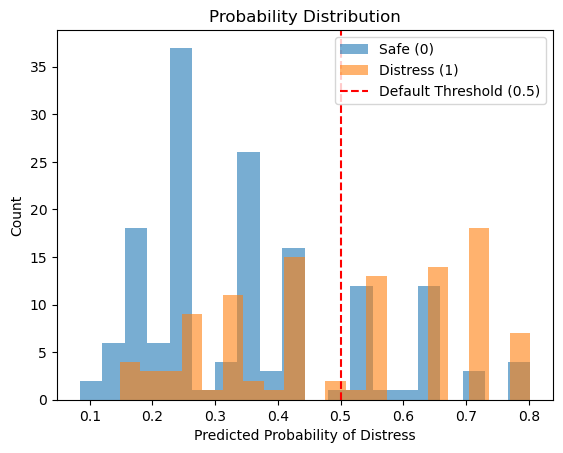

In [72]:
# Logistic Regression Probability Distribution

y_prob = lr.predict_proba(x_test)[:, 1]

plt.hist(y_prob[y_test == 0], bins=20, alpha=0.6, label="Safe (0)")
plt.hist(y_prob[y_test == 1], bins=20, alpha=0.6, label="Distress (1)")

plt.axvline(0.5, color='red', linestyle='--', label='Default Threshold (0.5)')
plt.legend()
plt.xlabel("Predicted Probability of Distress")
plt.ylabel("Count")
plt.title("Probability Distribution")
plt.show()


Based on Plot Probability Distribution, We can see the model is struggling to classify the companies at near to threshold of 0.35 and 0.55. Reason could be model is uncertain and features maynot strongly giving signal to classify the companies

In [73]:
y_prob = lr.predict_proba(x_test)[:, 1]

precision, recall, thresholds = metrics.precision_recall_curve(
    y_test,
    y_prob,
    pos_label=1
)


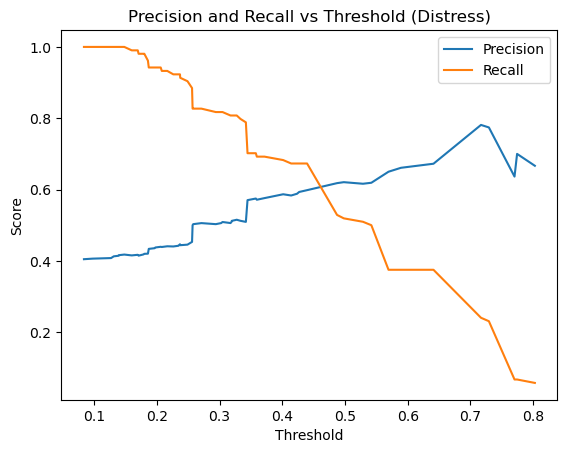

In [74]:
plt.plot(thresholds, precision[:-1])
plt.plot(thresholds, recall[:-1])

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold (Distress)")
plt.legend(["Precision", "Recall"])
plt.show()


As per Graph, the optimal threshold is 0.35-0.40 can be selected to improve the identifying of distress companies while maintaining resonable precision

In [75]:
# As per the graph, the optimal threshold is 0.40

y_prob = lr.predict_proba(x_test)[:, 1]

y_pred = np.where(y_prob >= 0.40, 1, 0)

print(metrics.classification_report(y_test, y_pred))
print(f'Accuracy---', metrics.accuracy_score(y_test, y_pred))
print(f'Roc_AUC Score---', metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71       153
           1       0.59      0.68      0.63       104

    accuracy                           0.68       257
   macro avg       0.67      0.68      0.67       257
weighted avg       0.69      0.68      0.68       257

Accuracy--- 0.6770428015564203
Roc_AUC Score--- 0.6779474610356965


In [76]:
y_prob_distress = lr.predict_proba(x_test)[:, 1]

auc_score = metrics.roc_auc_score(y_test, y_prob_distress)

y_pred = (y_prob_distress >= 0.4).astype(int)

binary_auc = metrics.roc_auc_score(y_test, y_pred)

print(f'Model ROC-AUC (Continuous): {auc_score:.2f}')
print(f'Operational AUC (at 0.40):  {binary_auc:.2f}')

Model ROC-AUC (Continuous): 0.71
Operational AUC (at 0.40):  0.68


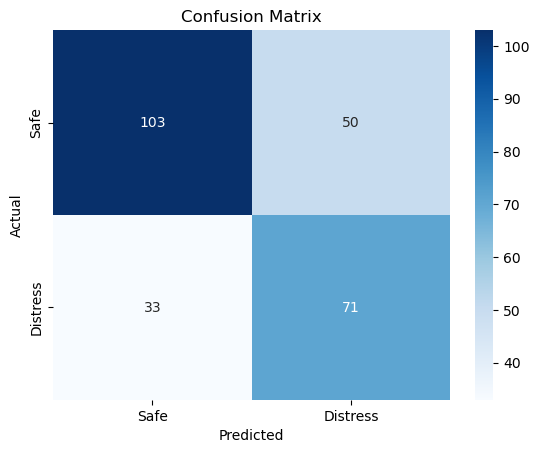

In [77]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe','Distress'],
            yticklabels=['Safe','Distress'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

The model correctly identified 71 distressed companies and 103 safe companies. It missed 33 distressed companies and wrongly flagged 50 safe companies as distressed.

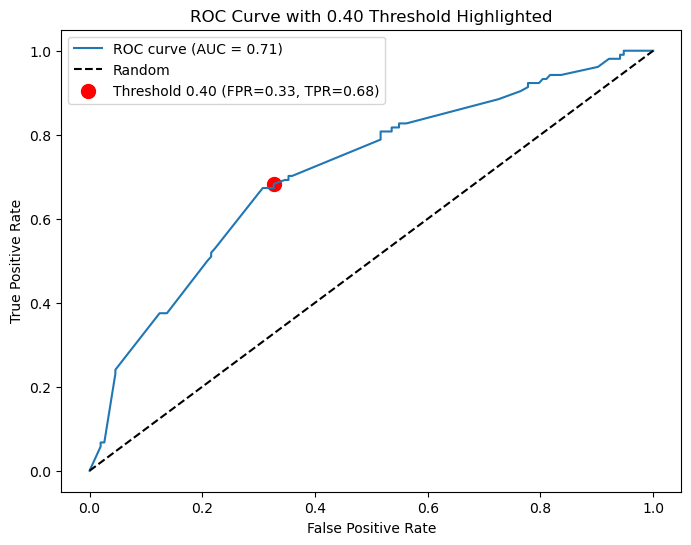

In [78]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# Find the index of the threshold closest to 0.40
idx = np.argmin(np.abs(thresholds - 0.40))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Highlight the 0.40 threshold point
plt.scatter(fpr[idx], tpr[idx], color='red', s=100, label=f'Threshold 0.40 (FPR={fpr[idx]:.2f}, TPR={tpr[idx]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with 0.40 Threshold Highlighted')
plt.legend()
plt.show()


The model can fairly separate distressed and safe companies (AUC = 0.71).
With a threshold of 0.40, it correctly detects 68% of distressed companies, but it also wrongly flags 33% of safe companies as distressed.

In [79]:
# Coefficients of Logistic Regression
coef_lr = pd.DataFrame({
    'Features': x_train.columns,
    'Coefficients': lr.coef_[0]
}).sort_values(by='Coefficients', ascending=False).reset_index(drop=True)

coef_lr

,Features,Coefficients
0,involvement_msci.Gambling,1.583167
1,Tempurature_aligned,0.171207
2,involvement_msci.Controversial Weapons,0.138847
3,Controversies_score_ESG,0.115407
4,SBTI_reduction_aligned,0.062939
5,involvement_msci.Alcoholic Beverages,-0.170084
6,involvement_msci.Tobacco Products,-0.294204
7,piotroski_score,-0.411495
8,global_target_aligned,-0.512903


# Model Interpretation

1. **Global Target Alignment & Financial Strength**  
   As per the model, firms aligned with global targets and having higher financial strength(Piotroski Score) show a higher probability of being in the Safe zone. This could be a combination of possible regulatory support and increased reputation due to company commitments towards net zero.

2. **Tobacco Involvement**  
   Tobacco involvement increases the probability of being Safe, which could be due to higher cash flow and margins of these companies. Overall, they appear financially stable and profitable.

3. **SBTI & Temperature Alignment**  
   SBTI and Temperature alignment commitments could put stress on companies as they spend on Transition (risk) towards sustainable business and align with future regulations.

4. **ESG Controversies & Weapons Involvement**  
   ESG controversies and involvement in weapons act as distress signals for companies, possibly due to regulatory pressure or reputational damage.

5. **Gambling Involvement**  
   Involvement in gambling shows a strong distress signal for companies. Major reasons could include regulatory restrictions, operational limitations in certain regions, and potential reputational damage causing companies to fall into severe categories.

# Model Limitations and Own Conclusions

### **Data Nature and Limitations**

 - The target variable is the Altman Z-Score, which measures bankruptcy risk. However, the dataset does not contain strong financial variables directly linked to the Altman components. As a result, the model performance is limited and works only within the scope of the available ESG and related features.

 - Despite limited information, the model was able to capture meaningful relationships and giving economically meaningful insights. The results suggest that ESG features and the Piotroski score may indirectly influence or relate to the Altman score, providing moderate predictive insight into financial distress.

**Dataset information** The dataset was obtained from Kaggle and around 2 years old. the model output and its meaning are not representing the current trends
